In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.image import imread
from PIL import Image
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from umap import UMAP

from sneakers_ml.features.features import load_features

In [2]:
def create_dataset(features_, classes_, idx_to_class, images_) -> pd.DataFrame:
    dataframe = pd.DataFrame(
        np.concatenate([features_, classes_.reshape(-1, 1), images_.reshape(-1, 1)], axis=1),
        columns=["feature_1", "feature_2", "class", "image"],
    )
    dataframe["feature_1"] = pd.to_numeric(dataframe["feature_1"])
    dataframe["feature_2"] = pd.to_numeric(dataframe["feature_2"])
    dataframe["class_name"] = dataframe["class"].apply(lambda x: idx_to_class[int(x)])
    top_classes = dataframe["class_name"].value_counts()[:10].index.to_list()
    return dataframe[dataframe["class_name"].isin(top_classes)]

# Получение эмбеддингов resnet для картинок по брендам

In [3]:
features, classes, class_to_idx = load_features("data/features/brands-classification/resnet.pickle")

In [4]:
idx_to_class = {v: k for k, v in class_to_idx.items()}
classes_idx = classes[:, 1]
images_idx = classes[:, 0]

# Сжатие с помощью SVD до двух компонент

/home/seara/.pyenv/versions/3.9.16/envs/DS/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


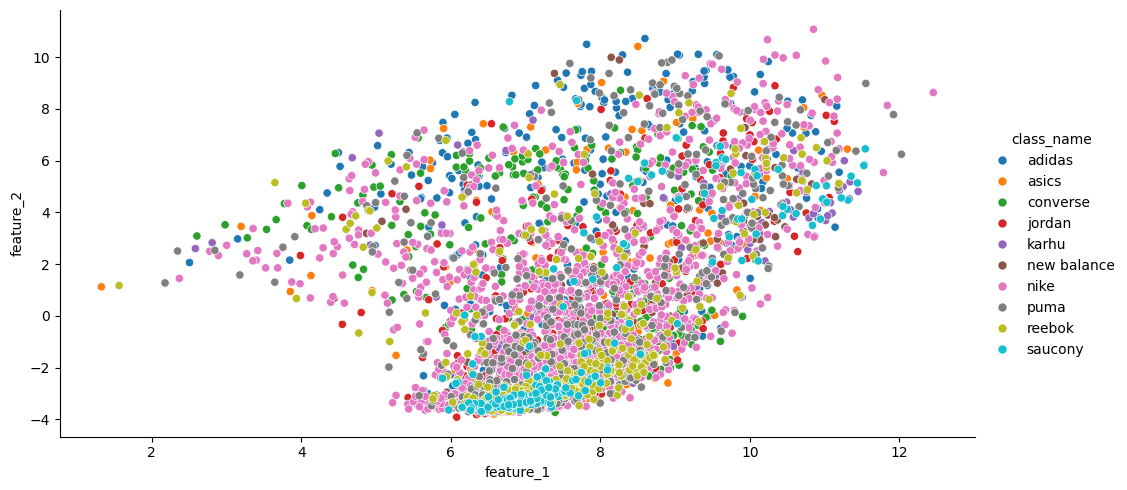

In [5]:
SVD_2 = TruncatedSVD(n_components=2).fit_transform(features)
dataframe = create_dataset(SVD_2, classes_idx, idx_to_class, images_idx)
sns.relplot(data=dataframe, x="feature_1", y="feature_2", hue="class_name", aspect=2)

# Сжатие с помощью PCA до двух компонент

/home/seara/.pyenv/versions/3.9.16/envs/DS/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


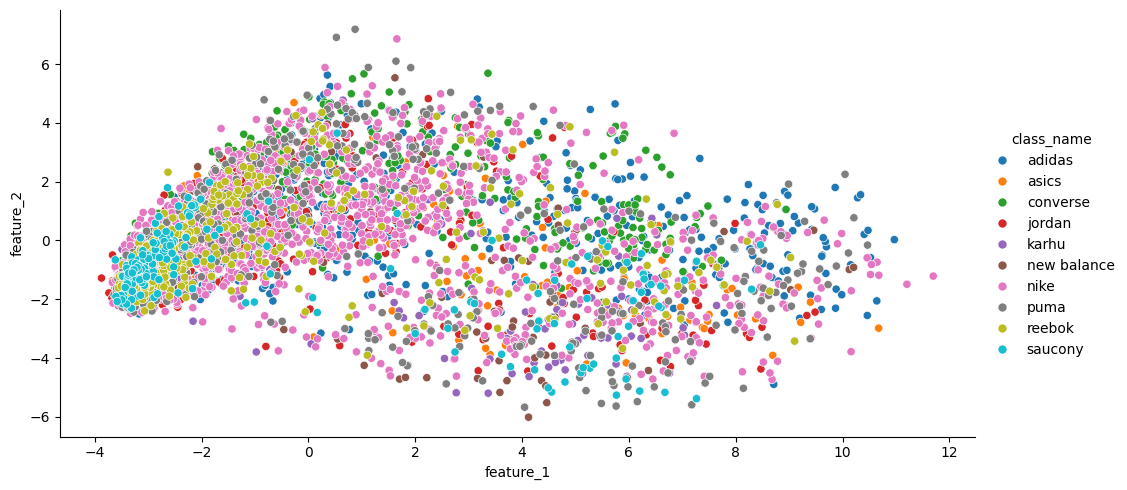

In [6]:
PCA_2 = PCA(n_components=2).fit_transform(features)
dataframe = create_dataset(PCA_2, classes_idx, idx_to_class, images_idx)
sns.relplot(data=dataframe, x="feature_1", y="feature_2", hue="class_name", aspect=2)

# TSNE до двух компонент (сначала сжимаем с помощью PCA до 50 компонент, потом уже TSNE до двух)

/home/seara/.pyenv/versions/3.9.16/envs/DS/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


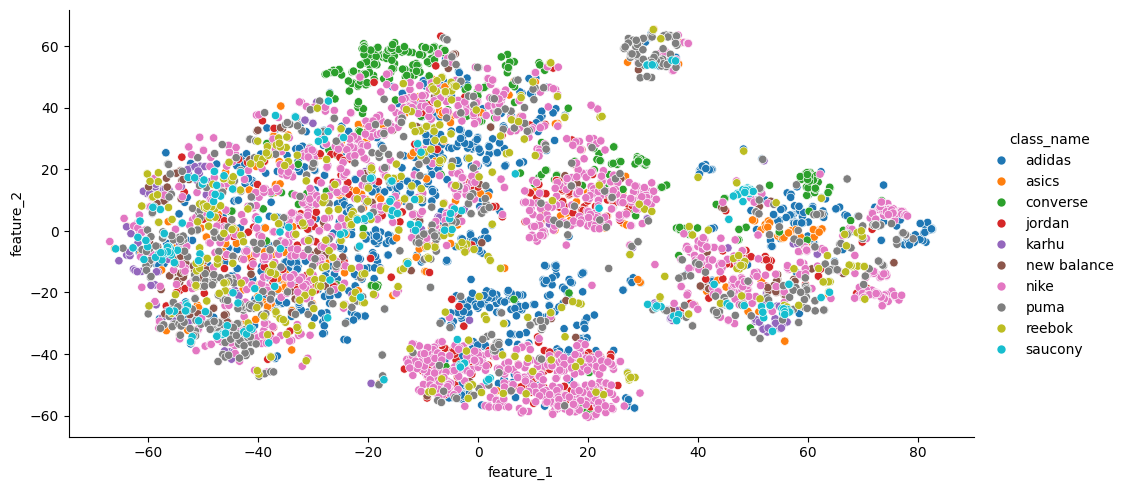

In [7]:
PCA_50 = PCA(n_components=50).fit_transform(features)
TSNE_2 = TSNE(n_components=2).fit_transform(PCA_50)
dataframe = create_dataset(TSNE_2, classes_idx, idx_to_class, images_idx)
sns.relplot(data=dataframe, x="feature_1", y="feature_2", hue="class_name", aspect=2)

# Видны кластеры, но они не соответствуют брендам - скорее всего они кучкуются по *ракурсам* изображений.

# Сделаем UMAP и посмотрим какие картинки в кластерах!!

/home/seara/.pyenv/versions/3.9.16/envs/DS/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


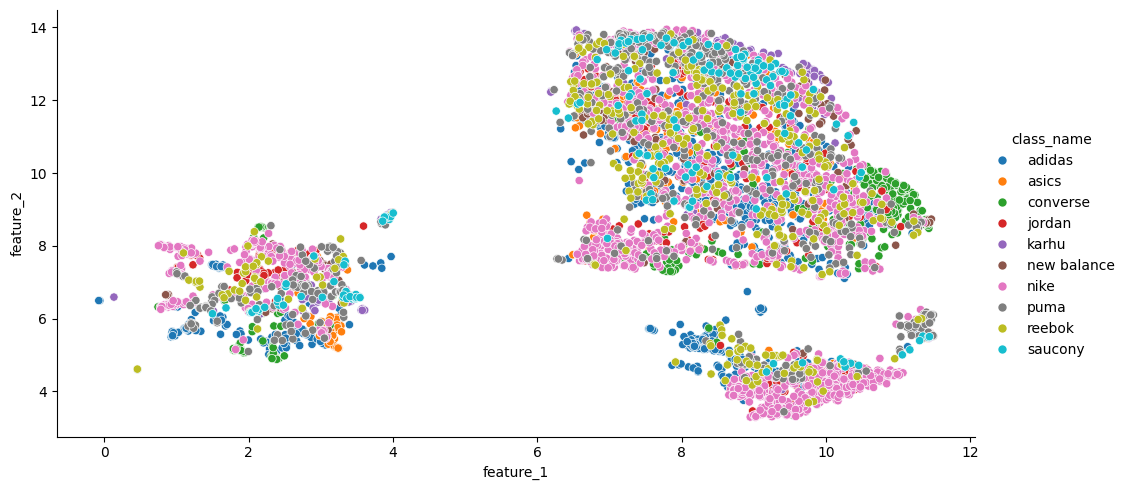

In [9]:
umap_model = UMAP(n_components=2, n_jobs=-1)
umap_embeddings = umap_model.fit_transform(features)
dataframe = create_dataset(umap_embeddings, classes_idx, idx_to_class, images_idx)
sns.relplot(data=dataframe, x="feature_1", y="feature_2", hue="class_name", aspect=2)

# Визуализируем самый левый пучок - там подошвы

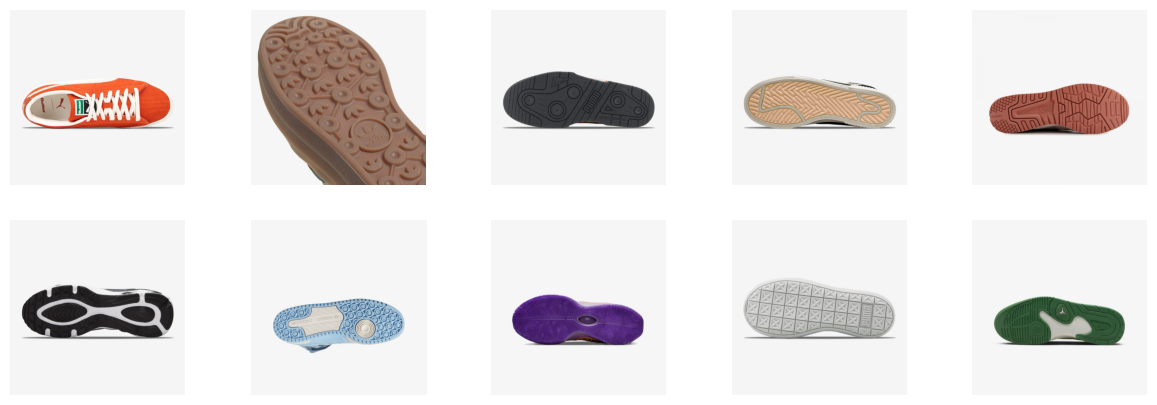

In [10]:
images = dataframe[dataframe["feature_1"] <= 6]["image"].sample(10).to_list()

fig, axes = plt.subplots(2, 5, figsize=(15, 5))

for idx, ax in enumerate(axes.flatten()):
    image = imread(images[idx])
    ax.imshow(image)
    ax.axis("off")

plt.show()

# Визуализируем правый нижний пучок

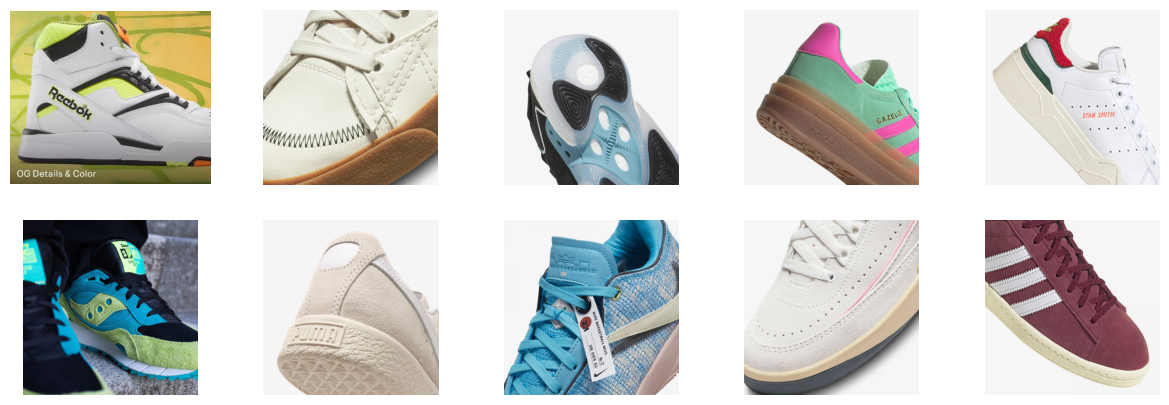

In [18]:
images = dataframe[(dataframe["feature_1"] >= 6) & (dataframe["feature_2"] <= 7)]["image"].sample(10).tolist()

fig, axes = plt.subplots(2, 5, figsize=(15, 5))

for idx, ax in enumerate(axes.flatten()):
    image = imread(images[idx])
    ax.imshow(image)
    ax.axis("off")

plt.show()

# Визуализируем самый большой верхний правый кластер

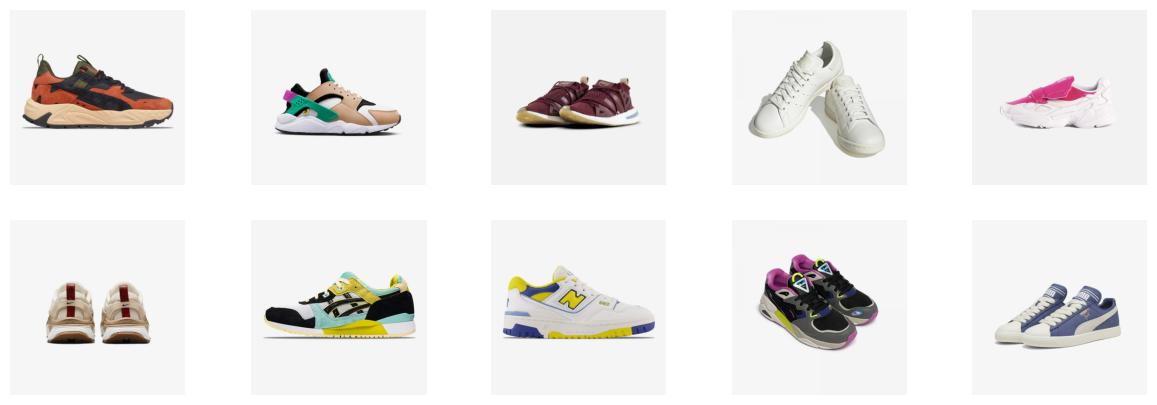

In [19]:
images = dataframe[(dataframe["feature_1"] >= 6) & (dataframe["feature_2"] >= 7.5)]["image"].sample(10).to_list()

fig, axes = plt.subplots(2, 5, figsize=(15, 5))

for idx, ax in enumerate(axes.flatten()):
    image = imread(images[idx])
    ax.imshow(image)
    ax.axis("off")

plt.show()

# Посмотрим можно ли удалить дубликаты - картинки с похожими эмбеддингами

In [20]:
similarity_matrix = cosine_similarity(features)
threshold = 0.99
paths = list(classes[:, 0])

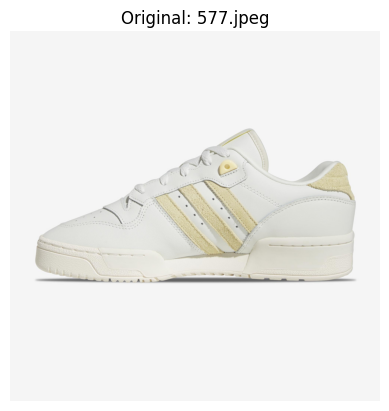

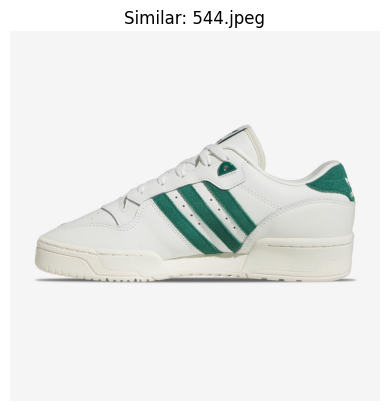

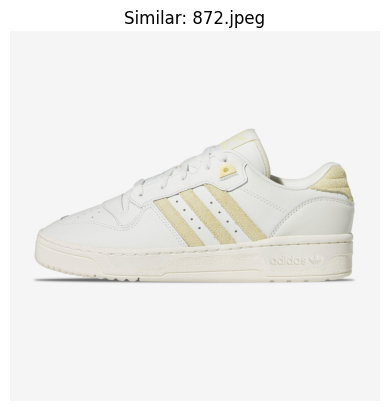

In [21]:
for i in range(len(paths)):
    similar_indices = np.where(similarity_matrix[i] > threshold)[0]

    if len(similar_indices) > 2:
        current_image_path = paths[i]
        current_image = Image.open(current_image_path)
        plt.imshow(current_image)
        plt.title(f"Original: {os.path.basename(current_image_path)}")
        plt.axis("off")
        plt.show()

        for idx in similar_indices:
            if idx != i:
                similar_image_path = paths[idx]
                similar_image = Image.open(similar_image_path)

                plt.imshow(similar_image)
                plt.title(f"Similar: {os.path.basename(similar_image_path)}")
                plt.axis("off")
                plt.show()
        break